# Requirements

In [1]:
# !python -m pip install pulse-eco[client,httpx]

In [2]:
import datetime
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
import seaborn as sns
import matplotlib.pyplot as plt
from pulseeco.client import PulseEcoClient, DataValueType, AveragePeriod
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

2025-03-13 12:06:48.733837: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 12:06:48.931212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741864009.010022    2673 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741864009.032807    2673 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 12:06:49.216549: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
pulse_eco = PulseEcoClient(city_name="skopje")

In [4]:
data_value_types = [
    DataValueType.NO2,
    DataValueType.O3,
    DataValueType.PM25,
    DataValueType.PM10,
    DataValueType.TEMPERATURE,
    DataValueType.HUMIDITY,
]

In [5]:
dates = pd.date_range(start="2020-01-01", end="2024-12-31", freq="d").strftime("%Y-%m-%d").tolist()

In [6]:
df = pd.DataFrame({"date": dates})
for data_value_type in data_value_types:
    data = pulse_eco.avg_data(
        period=AveragePeriod.DAY,
        from_=datetime.datetime(year=2020, month=1, day=1, hour=12),
        to=datetime.datetime(year=2024, month=12, day=1, hour=12),
        type=data_value_type,
        sensor_id="-1",
    )
    dates = list(map(lambda row: row.stamp, data))
    values = list(map(lambda row: row.value, data))

    new_df = pd.DataFrame({"date": dates, data_value_type.value: values})
    new_df["date"] = pd.to_datetime(new_df["date"], utc=True).dt.strftime("%Y-%m-%d")
    df = pd.merge(left=df, right=new_df, how="left", on="date") 
    df[data_value_type.value] = df[data_value_type.value].interpolate(method="linear")
    df[data_value_type.value] = df[data_value_type.value].ffill()
    df[data_value_type.value] = df[data_value_type.value].bfill()

In [7]:
df["date"] = pd.to_datetime(df["date"])

In [8]:
df.set_index(keys=["date"], inplace=True)

In [9]:
df.to_csv("data.csv")

In [8]:
df

,no2,o3,pm25,pm10,temperature,humidity
date,,,,,,
2020-01-01,14.0,4.0,37.0,65.0,7.0,49.0
2020-01-02,14.0,4.0,37.0,65.0,6.0,50.0
2020-01-03,14.0,4.0,56.0,101.0,6.0,48.0
2020-01-04,14.0,4.0,89.0,150.0,6.0,47.0
2020-01-05,14.0,4.0,19.0,33.0,6.0,52.0
...,...,...,...,...,...,...
2024-12-27,14.0,23.0,5.0,8.0,8.0,75.0
2024-12-28,14.0,23.0,5.0,8.0,8.0,75.0
2024-12-29,14.0,23.0,5.0,8.0,8.0,75.0


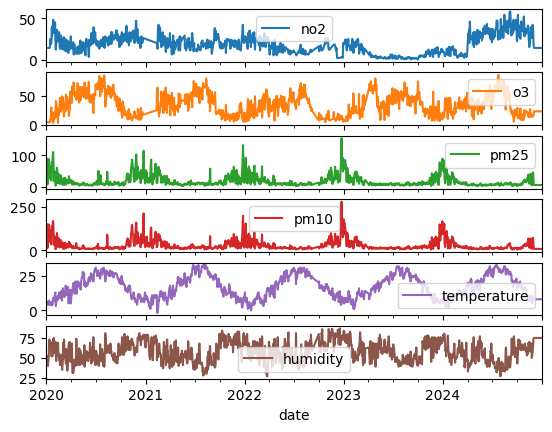

In [9]:
df.plot(subplots=True, legend=True);

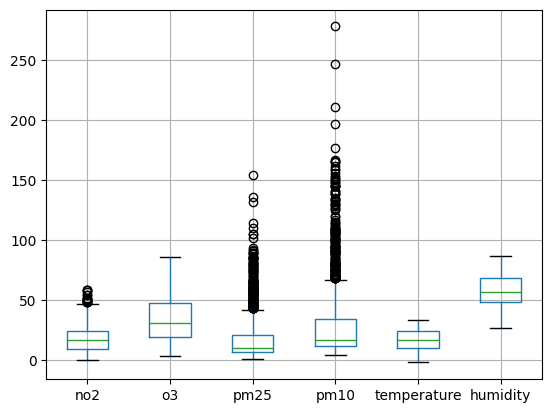

In [10]:
df.boxplot();

In [11]:
df["no2"].describe()

count    1827.000000
mean       17.805966
std        10.899319
min         0.000000
25%         9.114583
50%        17.000000
75%        24.500000
max        58.000000
Name: no2, dtype: float64

<Axes: xlabel='date'>

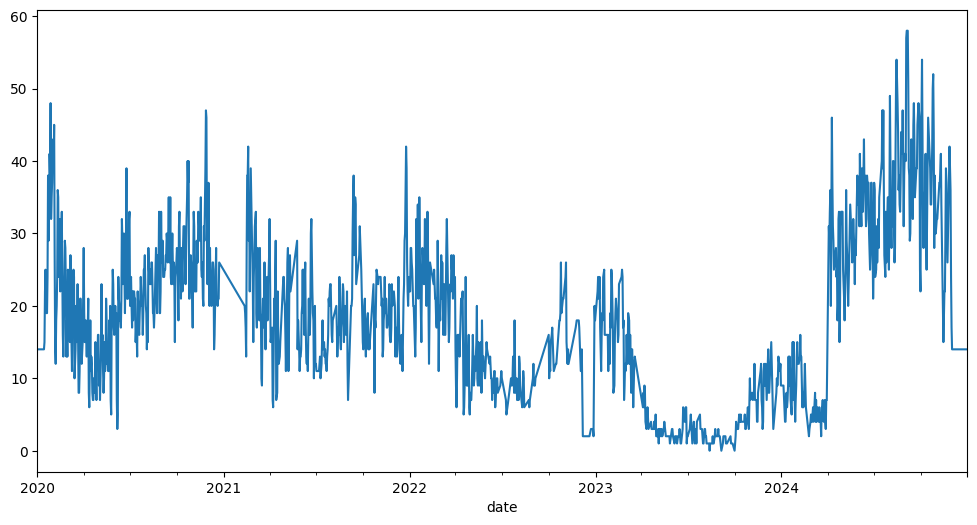

In [12]:
plt.figure(figsize=(12, 6))
df["no2"].plot()

<Axes: >

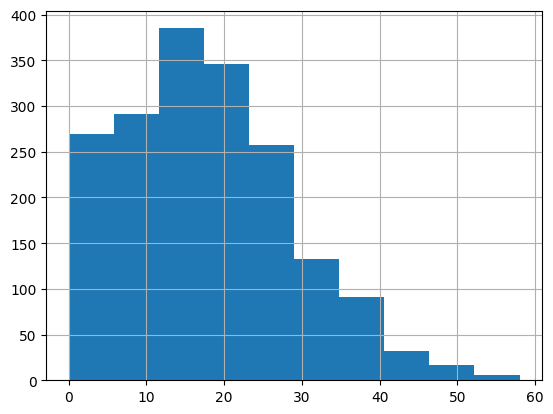

In [13]:
df["no2"].hist()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

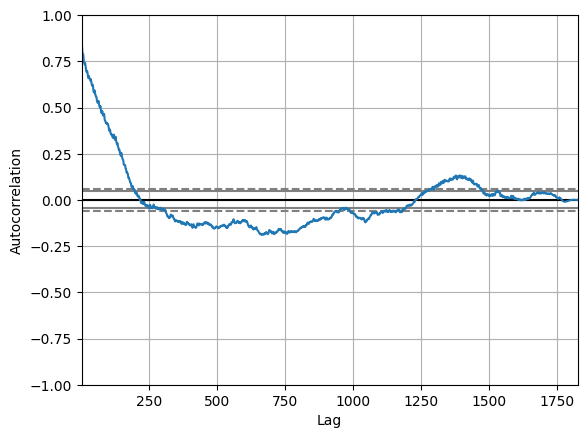

In [14]:
autocorrelation_plot(df["no2"])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

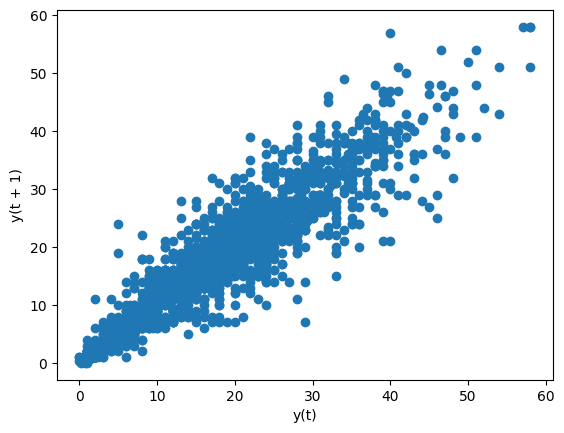

In [15]:
lag_plot(df["no2"], lag=1)

In [16]:
df["o3"].describe()

count    1827.000000
mean       33.689108
std        18.113651
min         3.000000
25%        19.000000
50%        31.000000
75%        47.857143
max        86.000000
Name: o3, dtype: float64

<Axes: xlabel='date'>

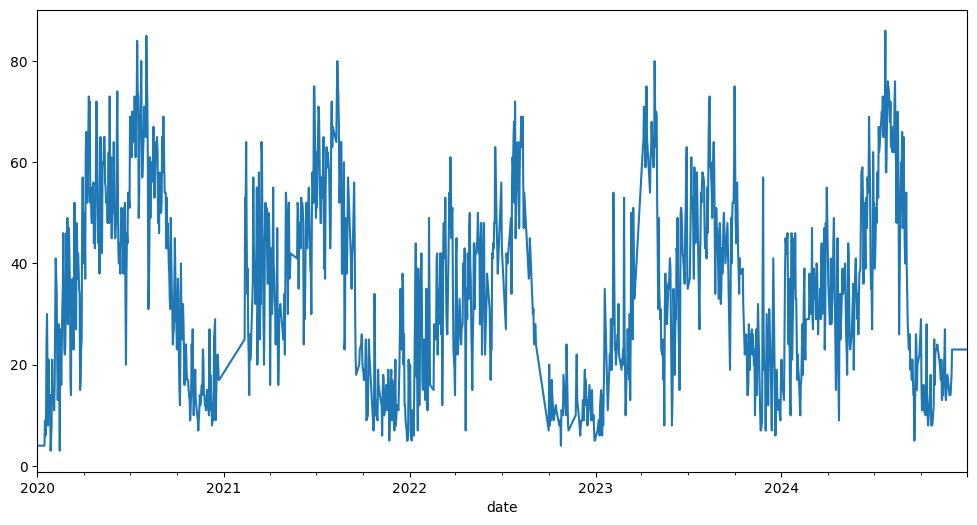

In [17]:
plt.figure(figsize=(12, 6))
df["o3"].plot()

<Axes: >

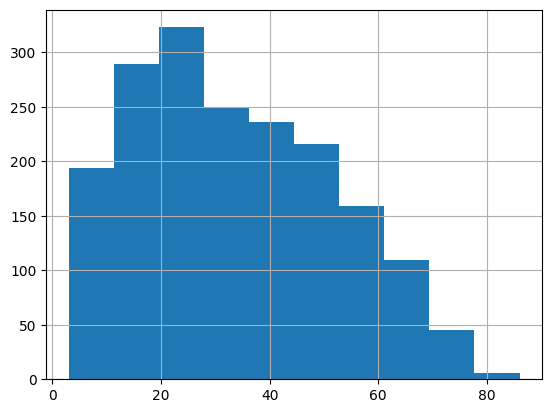

In [18]:
df["o3"].hist()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

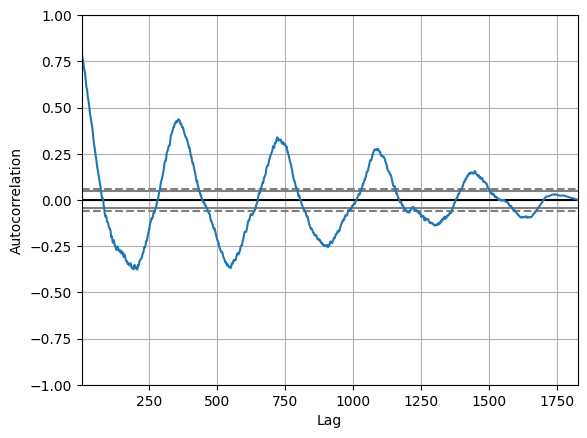

In [19]:
autocorrelation_plot(df["o3"])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

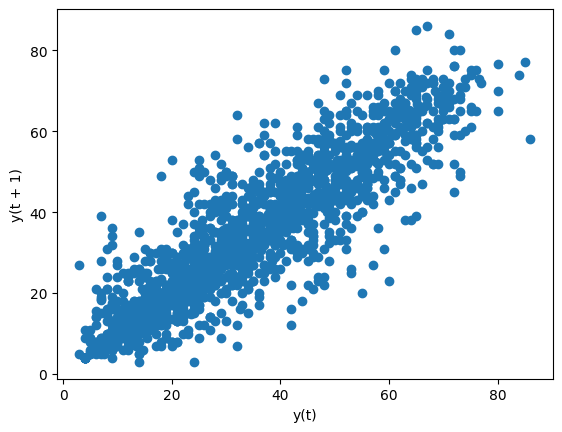

In [20]:
lag_plot(df["o3"], lag=1)

In [21]:
df["pm25"].describe()

count    1827.000000
mean       17.412425
std        17.761811
min         1.000000
25%         7.000000
50%        10.000000
75%        21.000000
max       154.000000
Name: pm25, dtype: float64

<Axes: xlabel='date'>

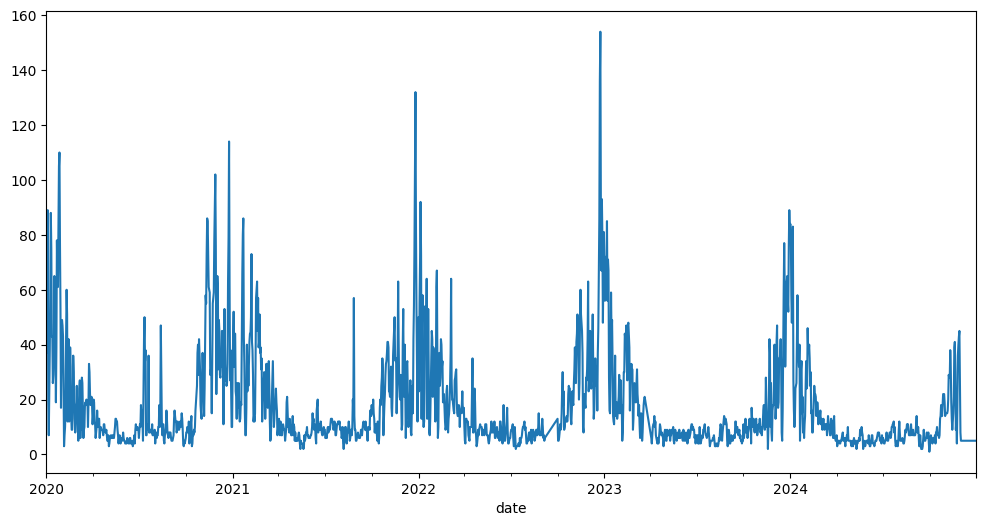

In [22]:
plt.figure(figsize=(12, 6))
df["pm25"].plot()

<Axes: >

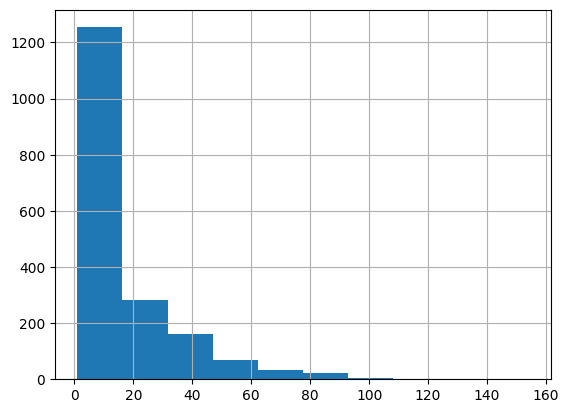

In [23]:
df["pm25"].hist()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

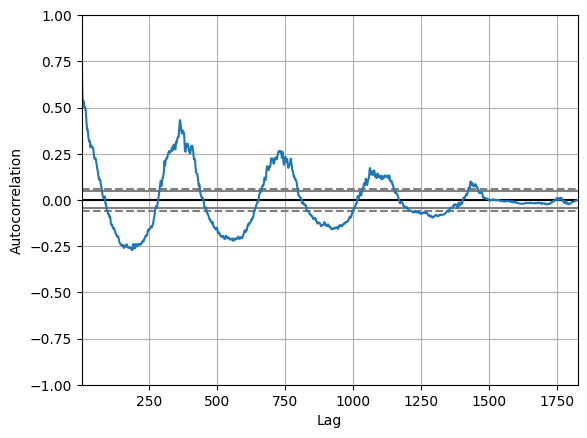

In [24]:
autocorrelation_plot(df["pm25"])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

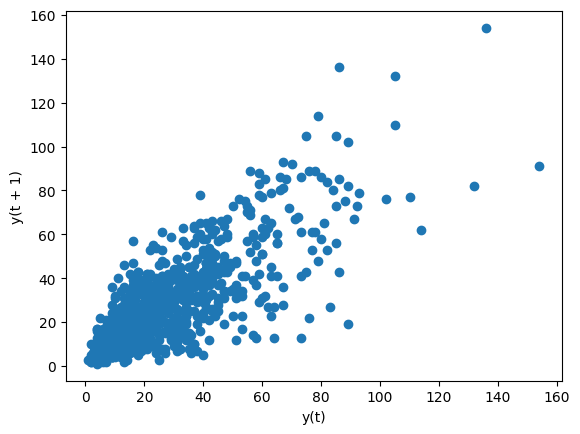

In [25]:
lag_plot(df["pm25"], lag=1)

In [26]:
df["pm10"].describe()

count    1827.000000
mean       28.838533
std        29.257699
min         4.000000
25%        12.000000
50%        17.000000
75%        34.000000
max       278.000000
Name: pm10, dtype: float64

<Axes: xlabel='date'>

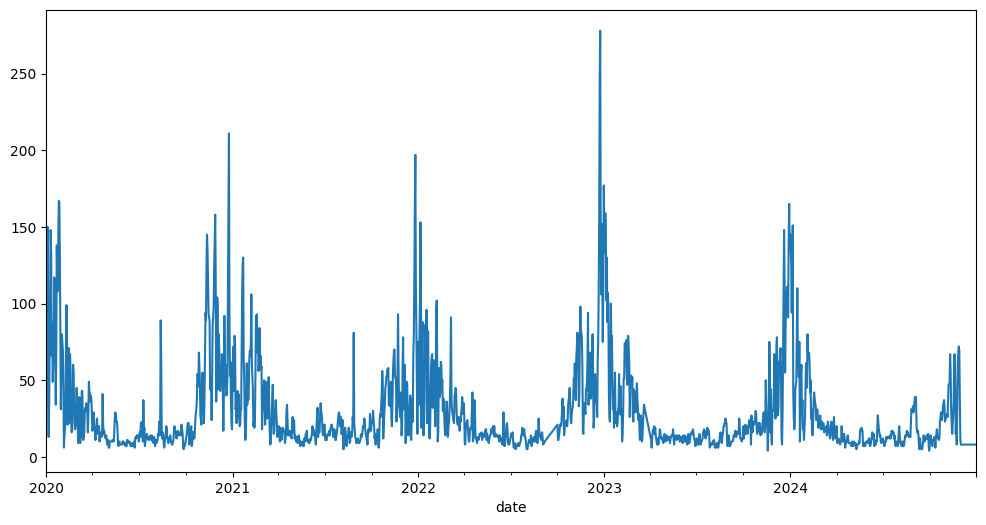

In [27]:
plt.figure(figsize=(12, 6))
df["pm10"].plot()

<Axes: >

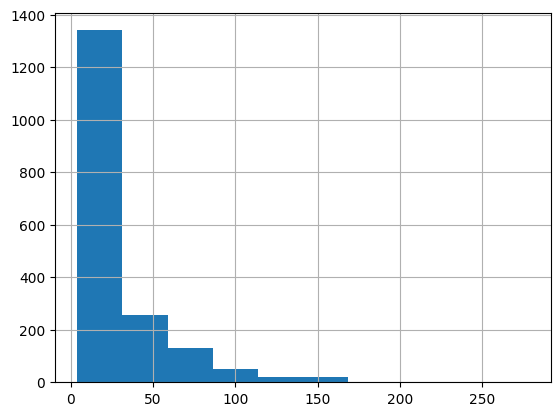

In [28]:
df["pm10"].hist()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

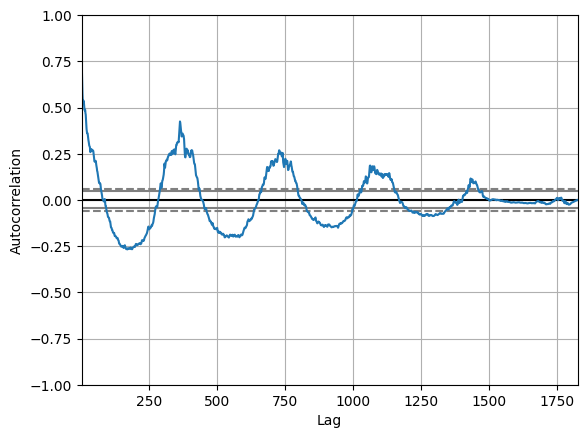

In [29]:
autocorrelation_plot(df["pm10"])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

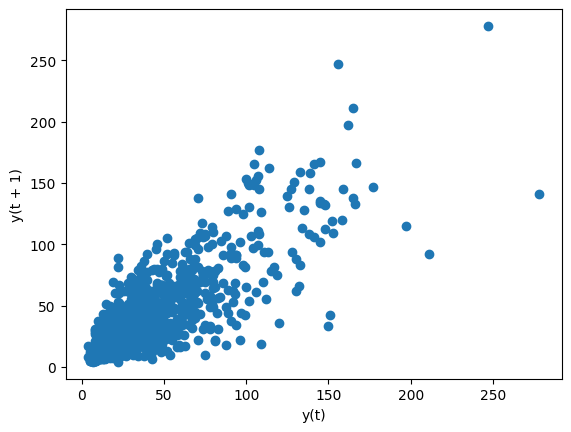

In [30]:
lag_plot(df["pm10"], lag=1)

In [31]:
df["temperature"].describe()

count    1827.000000
mean       17.050903
std         8.294603
min        -2.000000
25%        10.000000
50%        17.000000
75%        24.000000
max        33.000000
Name: temperature, dtype: float64

<Axes: xlabel='date'>

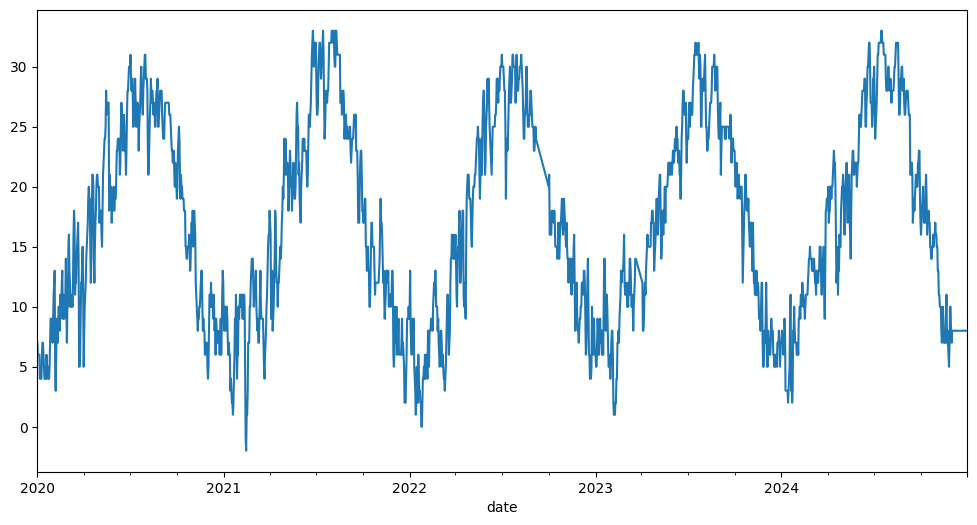

In [32]:
plt.figure(figsize=(12, 6))
df["temperature"].plot()

<Axes: >

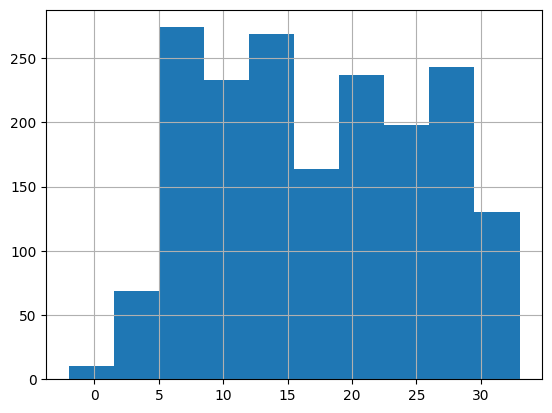

In [33]:
df["temperature"].hist()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

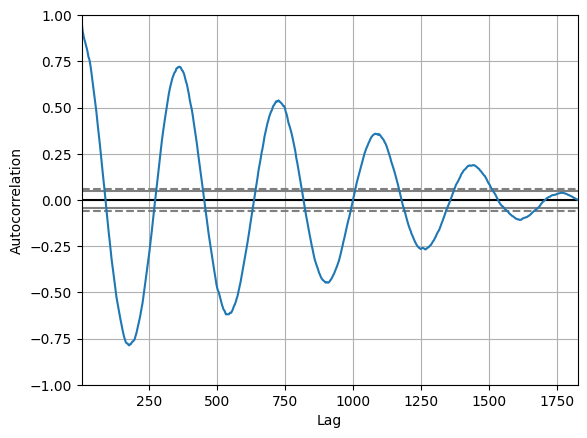

In [34]:
autocorrelation_plot(df["temperature"])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

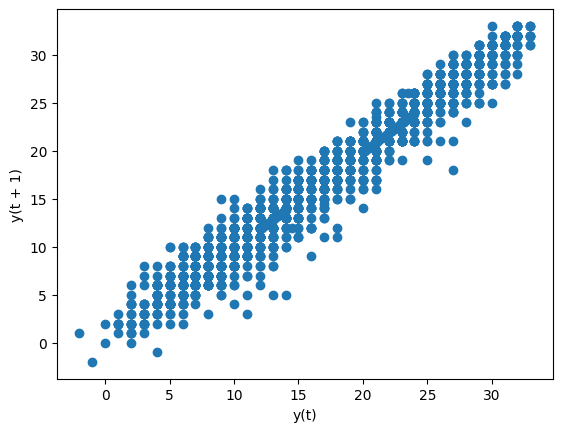

In [35]:
lag_plot(df["temperature"], lag=1)

In [36]:
df["humidity"].describe()

count    1827.000000
mean       57.713738
std        12.478954
min        27.000000
25%        48.000000
50%        57.000000
75%        68.000000
max        87.000000
Name: humidity, dtype: float64

<Axes: xlabel='date'>

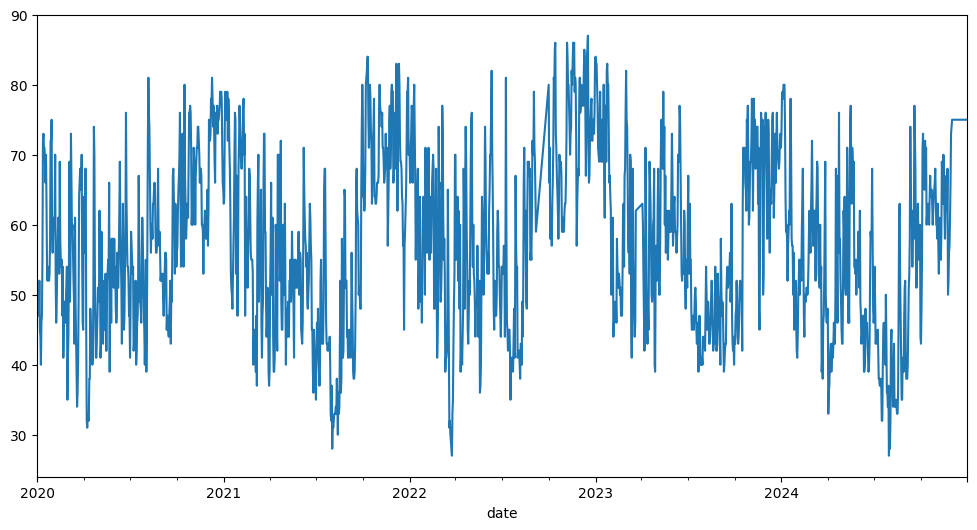

In [37]:
plt.figure(figsize=(12, 6))
df["humidity"].plot()

<Axes: >

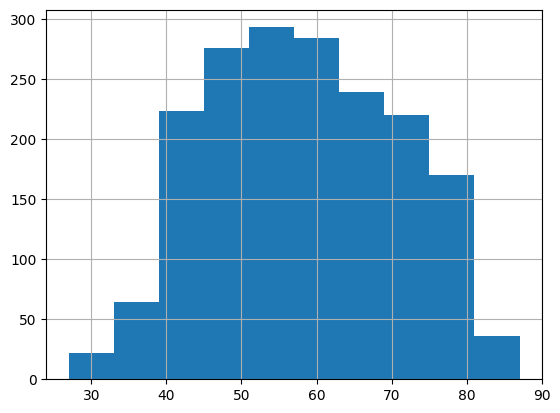

In [38]:
df["humidity"].hist()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

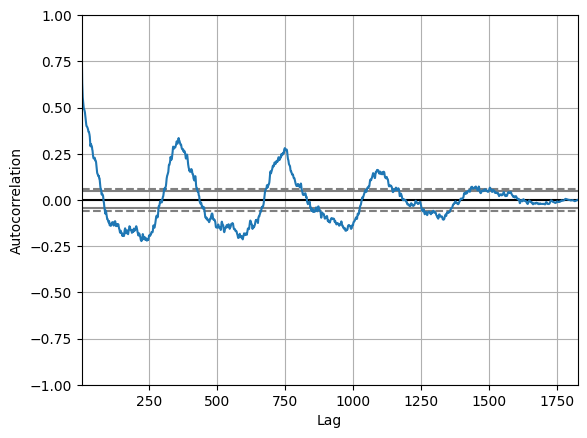

In [39]:
autocorrelation_plot(df["humidity"])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

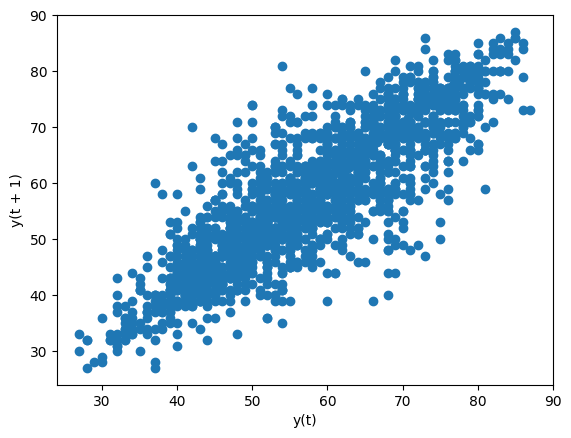

In [40]:
lag_plot(df["humidity"], lag=1)

In [41]:
features = ["no2", "o3", "pm25", "temperature", "humidity"]
target = "pm10"

In [42]:
lags = range(4, 0, -1)
list(lags)

[4, 3, 2, 1]

In [43]:
for lag in lags:
    for column in features + [target]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df

,no2,o3,pm25,pm10,temperature,humidity,no2_4,o3_4,pm25_4,temperature_4,...,pm25_2,temperature_2,humidity_2,pm10_2,no2_1,o3_1,pm25_1,temperature_1,humidity_1,pm10_1
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,14.0,4.0,37.0,65.0,7.0,49.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,14.0,4.0,37.0,65.0,6.0,50.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.0,4.0,37.0,7.0,49.0,65.0
2020-01-03,14.0,4.0,56.0,101.0,6.0,48.0,NaN,NaN,NaN,NaN,...,37.0,7.0,49.0,65.0,14.0,4.0,37.0,6.0,50.0,65.0
2020-01-04,14.0,4.0,89.0,150.0,6.0,47.0,NaN,NaN,NaN,NaN,...,37.0,6.0,50.0,65.0,14.0,4.0,56.0,6.0,48.0,101.0
2020-01-05,14.0,4.0,19.0,33.0,6.0,52.0,14.0,4.0,37.0,7.0,...,56.0,6.0,48.0,101.0,14.0,4.0,89.0,6.0,47.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,14.0,23.0,5.0,8.0,8.0,75.0,14.0,23.0,5.0,8.0,...,5.0,8.0,75.0,8.0,14.0,23.0,5.0,8.0,75.0,8.0
2024-12-28,14.0,23.0,5.0,8.0,8.0,75.0,14.0,23.0,5.0,8.0,...,5.0,8.0,75.0,8.0,14.0,23.0,5.0,8.0,75.0,8.0
2024-12-29,14.0,23.0,5.0,8.0,8.0,75.0,14.0,23.0,5.0,8.0,...,5.0,8.0,75.0,8.0,14.0,23.0,5.0,8.0,75.0,8.0


In [44]:
df.drop(columns=features, inplace=True)

In [45]:
df.dropna(axis=0, inplace=True)

In [46]:
df

,pm10,no2_4,o3_4,pm25_4,temperature_4,humidity_4,pm10_4,no2_3,o3_3,pm25_3,...,pm25_2,temperature_2,humidity_2,pm10_2,no2_1,o3_1,pm25_1,temperature_1,humidity_1,pm10_1
date,,,,,,,,,,,,,,,,,,,,,
2020-01-05,33.0,14.0,4.0,37.0,7.0,49.0,65.0,14.0,4.0,37.0,...,56.0,6.0,48.0,101.0,14.0,4.0,89.0,6.0,47.0,150.0
2020-01-06,13.0,14.0,4.0,37.0,6.0,50.0,65.0,14.0,4.0,56.0,...,89.0,6.0,47.0,150.0,14.0,4.0,19.0,6.0,52.0,33.0
2020-01-07,34.0,14.0,4.0,56.0,6.0,48.0,101.0,14.0,4.0,89.0,...,19.0,6.0,52.0,33.0,14.0,4.0,7.0,4.0,45.0,13.0
2020-01-08,70.0,14.0,4.0,89.0,6.0,47.0,150.0,14.0,4.0,19.0,...,7.0,4.0,45.0,13.0,14.0,4.0,21.0,4.0,44.0,34.0
2020-01-09,105.0,14.0,4.0,19.0,6.0,52.0,33.0,14.0,4.0,7.0,...,21.0,4.0,44.0,34.0,14.0,4.0,38.0,4.0,40.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,8.0,14.0,23.0,5.0,8.0,75.0,8.0,14.0,23.0,5.0,...,5.0,8.0,75.0,8.0,14.0,23.0,5.0,8.0,75.0,8.0
2024-12-28,8.0,14.0,23.0,5.0,8.0,75.0,8.0,14.0,23.0,5.0,...,5.0,8.0,75.0,8.0,14.0,23.0,5.0,8.0,75.0,8.0
2024-12-29,8.0,14.0,23.0,5.0,8.0,75.0,8.0,14.0,23.0,5.0,...,5.0,8.0,75.0,8.0,14.0,23.0,5.0,8.0,75.0,8.0


In [47]:
X, y = df.drop(columns=[target]), df[target]

In [48]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)

In [49]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [50]:
regressor = XGBRegressor(n_estimators=30).fit(train_X, train_y)

In [51]:
pred_y = regressor.predict(test_X)

In [52]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(7.150847603523568, 132.1423664383272, 0.6797107818442164)

In [53]:
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators": [15, 20, 25, 30, 35, 40],
        "max_depth": [2, 3, 4, 5, 6, 7]
    },
    cv=TimeSeriesSplit(n_splits=5)
)

In [54]:
grid_search.fit(train_X, train_y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [15, 20, 25, 30, 35, 40]})

In [55]:
grid_search.best_params_

{'max_depth': 2, 'n_estimators': 15}

In [56]:
regressor = XGBRegressor(n_estimators=15, max_depth=2).fit(train_X, train_y)

In [57]:
pred_y = regressor.predict(test_X)

In [58]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(6.791014688308925, 119.52951857457495, 0.7102820459276735)

<Axes: xlabel='date'>

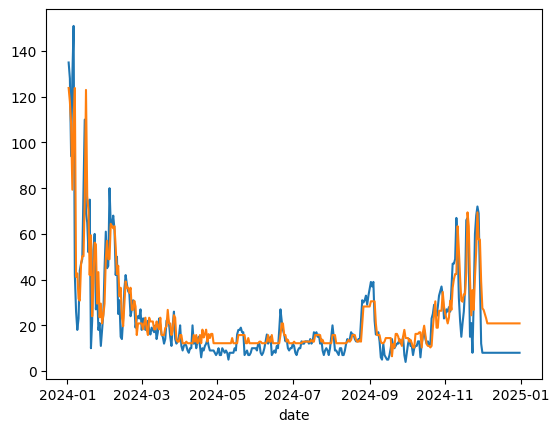

In [59]:
sns.lineplot(x=test_y.index, y=test_y.values)
sns.lineplot(x=test_y.index, y=pred_y)

In [60]:
scaler = MinMaxScaler()
train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))

In [61]:
train_X = train_X.reshape((train_X.shape[0], lag, (train_X.shape[1] // lag)))
test_X = test_X.reshape((test_X.shape[0], lag, (test_X.shape[1] // lag)))

In [62]:
model = Sequential([
    Input((train_X.shape[1], train_X.shape[2],)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])

I0000 00:00:1741719158.599406    2635 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [63]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,233 (137.63 KB)

 Trainable params: 35,233 (137.63 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [65]:
history = model.fit(train_X, train_y, validation_split=0.20, epochs=16, batch_size=4, shuffle=False)

Epoch 1/16


I0000 00:00:1741719161.382454    2990 service.cc:148] XLA service 0x7f2838005800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741719161.382676    2990 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-03-11 19:52:41.446016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741719161.718977    2990 cuda_dnn.cc:529] Loaded cuDNN version 90300


 58/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0440 - mean_squared_error: 0.0440

I0000 00:00:1741719163.394343    2990 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 2/16
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 3/16
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 4/16
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 5/16
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 6/16
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 7/16
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0021 - val_m

<Axes: >

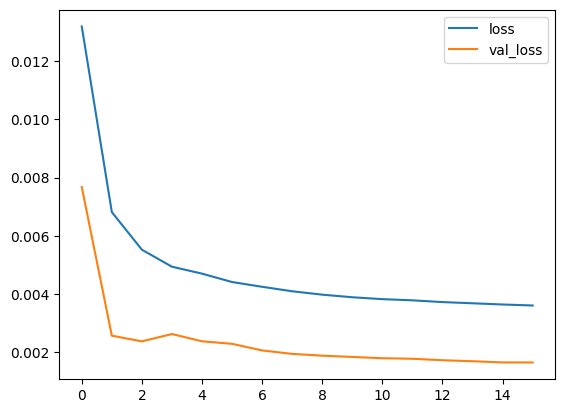

In [66]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [67]:
pred_y = model.predict(test_X)

2025-03-11 19:53:09.426815: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 12 bytes spill stores, 12 bytes spill loads



12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step 


In [68]:
pred_y = scaler.inverse_transform(pred_y)

In [69]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(7.213023386916069, 115.68694353149965, 0.7195957534797923)